In [1]:
!pip install xgboost


In [3]:
import xgboost as xgb
print(xgb.__version__)


2.1.3


In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeRegressor
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [3]:


# Load the dataset
data = pd.read_csv('train.csv')

# Display the first few rows of the dataset
print("First 5 rows of the dataset:")
print(data.head())

# Display the shape of the dataset
print("\nShape of the dataset:")
print(data.shape)

# Display summary information about the dataset
print("\nSummary of the dataset:")
print(data.info())

# Display basic statistics of the dataset
print("\nBasic statistics of the dataset:")
print(data.describe())


First 5 rows of the dataset:
   beds  baths    size size_units  lot_size lot_size_units  zip_code  \
0     3    2.5  2590.0       sqft   6000.00           sqft     98144   
1     4    2.0  2240.0       sqft      0.31           acre     98106   
2     4    3.0  2040.0       sqft   3783.00           sqft     98107   
3     4    3.0  3800.0       sqft   5175.00           sqft     98199   
4     2    2.0  1042.0       sqft       NaN            NaN     98102   

       price  
0   795000.0  
1   915000.0  
2   950000.0  
3  1950000.0  
4   950000.0  

Shape of the dataset:
(2016, 8)

Summary of the dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2016 entries, 0 to 2015
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   beds            2016 non-null   int64  
 1   baths           2016 non-null   float64
 2   size            2016 non-null   float64
 3   size_units      2016 non-null   object 
 4   lot_size 

In [4]:
# Check for missing values
missing_values = data.isnull().sum()
missing_values = missing_values[missing_values > 0]  # Filter out columns without missing values

# Display missing values
print("Columns with missing values:")
print(missing_values)

# Check data types
data_types = data.dtypes

# Display data types
print("\nData types of each column:")
print(data_types)

Columns with missing values:
lot_size          347
lot_size_units    347
dtype: int64

Data types of each column:
beds                int64
baths             float64
size              float64
size_units         object
lot_size          float64
lot_size_units     object
zip_code            int64
price             float64
dtype: object


In [5]:
# Fill missing categorical values with the mode
for column in data.select_dtypes(include=['object']).columns:
    data[column] = data[column].fillna(data[column].mode()[0])

print("Missing values after imputation:")
print(data.isnull().sum().sum())  # Should be 0 if all missing values were handled

Missing values after imputation:
347


In [6]:
missing_values = data.isnull().sum()


In [7]:
print(missing_values)

beds                0
baths               0
size                0
size_units          0
lot_size          347
lot_size_units      0
zip_code            0
price               0
dtype: int64


In [8]:
# Check for missing values in the 'lot_size' column
missing_lot_size = data['lot_size'].isnull().sum()
print(f"Missing values in 'lot_size': {missing_lot_size}")

# Impute missing values with the median (or mean)
data['lot_size'] = data['lot_size'].fillna(data['lot_size'].median())

# Verify if there are still missing values in 'lot_size'
remaining_missing_lot_size = data['lot_size'].isnull().sum()
print(f"Missing values in 'lot_size' after imputation: {remaining_missing_lot_size}")


Missing values in 'lot_size': 347
Missing values in 'lot_size' after imputation: 0


In [9]:
# Identify categorical columns
categorical_cols = data.select_dtypes(include=['object']).columns

# Option 1: Label Encoding (for ordinal variables)
# If you have ordinal variables, you can specify the order
# Example: data['ordinal_column'] = data['ordinal_column'].map({'Low': 1, 'Medium': 2, 'High': 3})

# Option 2: One-Hot Encoding (for nominal variables)
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

# Display the first few rows of the modified DataFrame
print(data.head())

   beds  baths    size  lot_size  zip_code      price  lot_size_units_sqft
0     3    2.5  2590.0   6000.00     98144   795000.0                 True
1     4    2.0  2240.0      0.31     98106   915000.0                False
2     4    3.0  2040.0   3783.00     98107   950000.0                 True
3     4    3.0  3800.0   5175.00     98199  1950000.0                 True
4     2    2.0  1042.0   4000.00     98102   950000.0                 True


In [10]:
# Drop the 'lot_size_units_sqft' column
data = data.drop(columns=['lot_size_units_sqft'])

# Display the first few rows of the modified DataFrame
print(data.head())


   beds  baths    size  lot_size  zip_code      price
0     3    2.5  2590.0   6000.00     98144   795000.0
1     4    2.0  2240.0      0.31     98106   915000.0
2     4    3.0  2040.0   3783.00     98107   950000.0
3     4    3.0  3800.0   5175.00     98199  1950000.0
4     2    2.0  1042.0   4000.00     98102   950000.0


In [11]:


# Select numerical features
numerical_features = ['beds', 'baths', 'size', 'lot_size', 'zip_code', 'price']

# Standardization
standard_scaler = StandardScaler()
data[numerical_features] = standard_scaler.fit_transform(data[numerical_features])

# Alternatively, for Min-Max Scaling
# min_max_scaler = MinMaxScaler()
# data[numerical_features] = min_max_scaler.fit_transform(data[numerical_features])

# Display the first few rows of the scaled DataFrame
print(data.head())


       beds     baths      size  lot_size  zip_code     price
0  0.113455  0.339428  0.928639  0.851534  0.899136 -0.178655
1  0.910407 -0.159687  0.548165 -1.573504 -0.778924 -0.051517
2  0.910407  0.838542  0.330751 -0.044564 -0.734764 -0.014436
3  0.910407  0.838542  2.243994  0.518074  3.327907  1.045042
4 -0.683497 -0.159687 -0.754144  0.043146 -0.955562 -0.014436


Text(0, 0.5, 'Frequency')

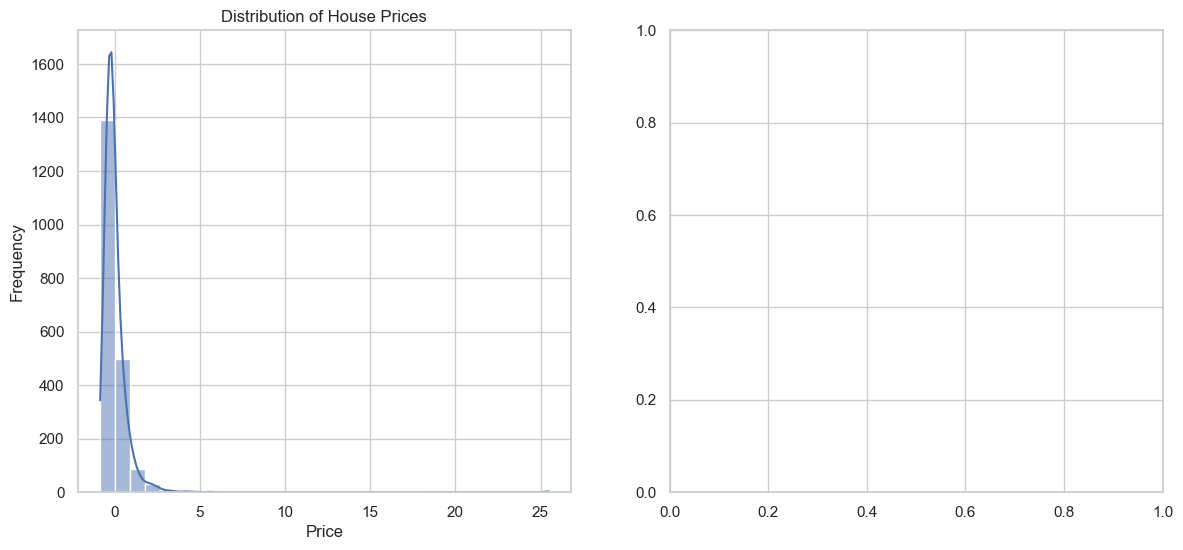

In [12]:
# Set the style for seaborn
sns.set(style="whitegrid")
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Histogram
sns.histplot(data['price'], bins=30, kde=True, ax=axes[0])
axes[0].set_title('Distribution of House Prices')
axes[0].set_xlabel('Price')
axes[0].set_ylabel('Frequency')


In [13]:
# Box Plot
sns.boxplot(x=data['price'], ax=axes[1])
axes[1].set_title('Box Plot of House Prices')
axes[1].set_xlabel('Price')

# Show the plots
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [14]:
# Calculate the correlation matrix
correlation_matrix = data.corr()


In [15]:
# Display the correlation of features with the target variable (price)
price_correlations = correlation_matrix['price'].sort_values(ascending=False)
print("Correlations with Price:")
print(price_correlations)

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))


Correlations with Price:
price       1.000000
size        0.444140
baths       0.317325
beds        0.293516
lot_size    0.085713
zip_code   -0.047189
Name: price, dtype: float64


<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

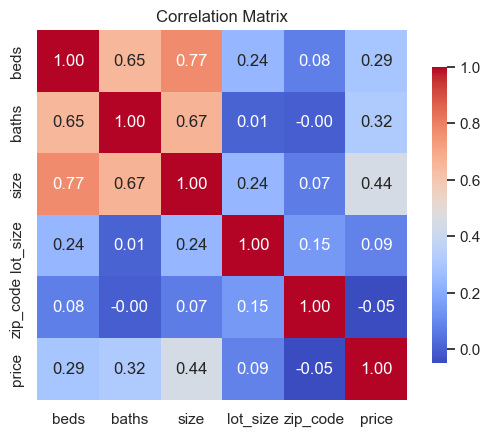

In [16]:
# Create a heatmap
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})

# Title and labels
plt.title('Correlation Matrix')
plt.show()

In [24]:


# Assuming df is your dataset and 'price' is the target variable
price_scaler = StandardScaler()
data[['price']] = price_scaler.fit_transform(data[['price']])

In [25]:
# Define features and target variable
X = data.drop('price', axis=1)  # Features
y = data['price']                 # Target variable


In [26]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [27]:
# Display the shapes of the splits
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (1612, 5) (1612,)
Testing set shape: (404, 5) (404,)


In [28]:
# Initialize the models
linear_model = LinearRegression()
decision_tree_model = DecisionTreeRegressor(random_state=42)
random_forest_model = RandomForestRegressor(random_state=42)
xgboost_model = xgb.XGBRegressor(random_state=42)


In [29]:
# Train the models
linear_model.fit(X_train, y_train)
decision_tree_model.fit(X_train, y_train)
random_forest_model.fit(X_train, y_train)
xgboost_model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [30]:
# Save the trained model
import joblib
joblib.dump(xgboost_model, 'xgboost_model.pkl')


['xgboost_model.pkl']

In [31]:
joblib.dump(standard_scaler, 'standard_scaler.pkl')

['standard_scaler.pkl']

In [47]:
# Make predictions
linear_predictions = linear_model.predict(X_test)
decision_tree_predictions = decision_tree_model.predict(X_test)
random_forest_predictions = random_forest_model.predict(X_test)
xgboost_predictions = xgboost_model.predict(X_test)


In [49]:
# Function to evaluate models
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    
    print(f"{model_name} Evaluation:")
    print(f" - MAE: {mae:.2f}")
    print(f" - RMSE: {rmse:.2f}")
    print(f" - R²: {r2:.2f}\n")

In [51]:
# Evaluate each model
evaluate_model(y_test, linear_predictions, "Linear Regression")
evaluate_model(y_test, decision_tree_predictions, "Decision Tree")
evaluate_model(y_test, random_forest_predictions, "Random Forest")
# evaluate_model(y_test, xgboost_predictions, "XGBoost")  # Uncomment if using XGBoost

Linear Regression Evaluation:
 - MAE: 0.23
 - RMSE: 0.39
 - R²: 0.59

Decision Tree Evaluation:
 - MAE: 0.25
 - RMSE: 0.47
 - R²: 0.41

Random Forest Evaluation:
 - MAE: 0.22
 - RMSE: 0.50
 - R²: 0.32



In [53]:
# Analyzing Residuals
def plot_residuals(y_true, y_pred, model_name):
    residuals = y_true - y_pred
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_pred, y=residuals)
    plt.axhline(0, color='red', linestyle='--')
    plt.title(f'Residuals for {model_name}')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.show()

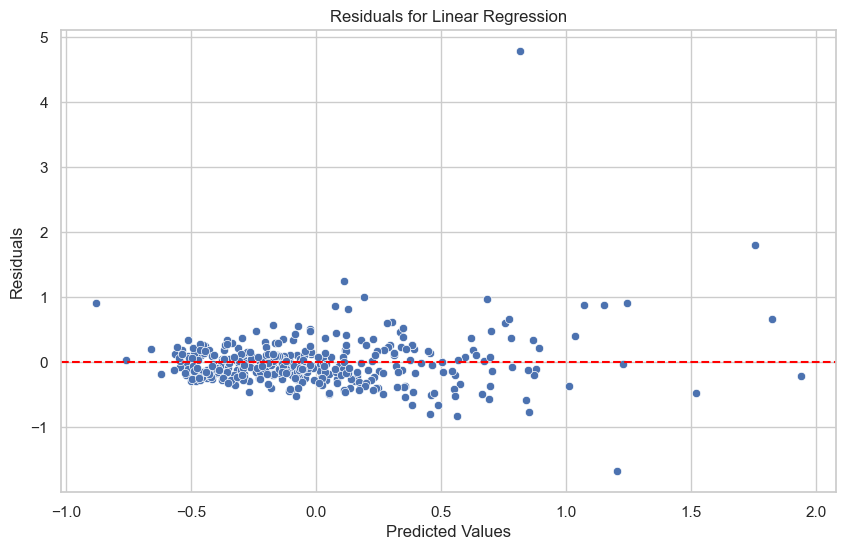

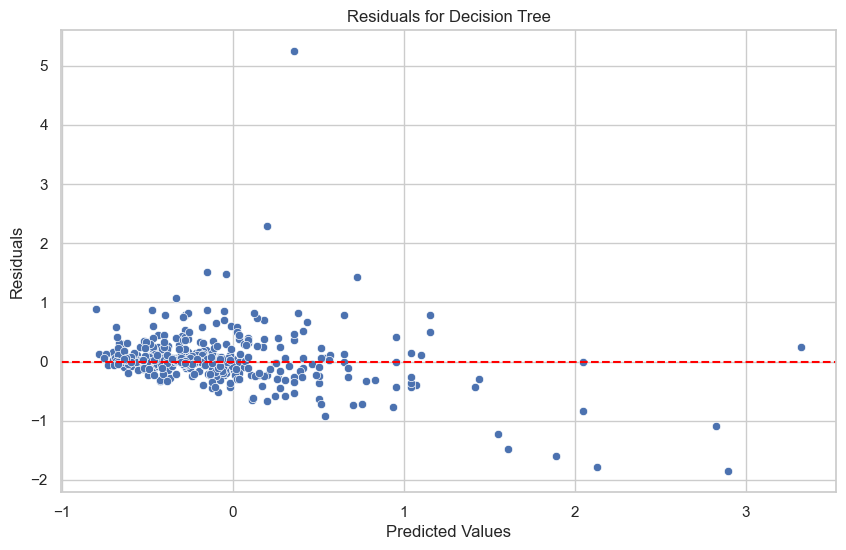

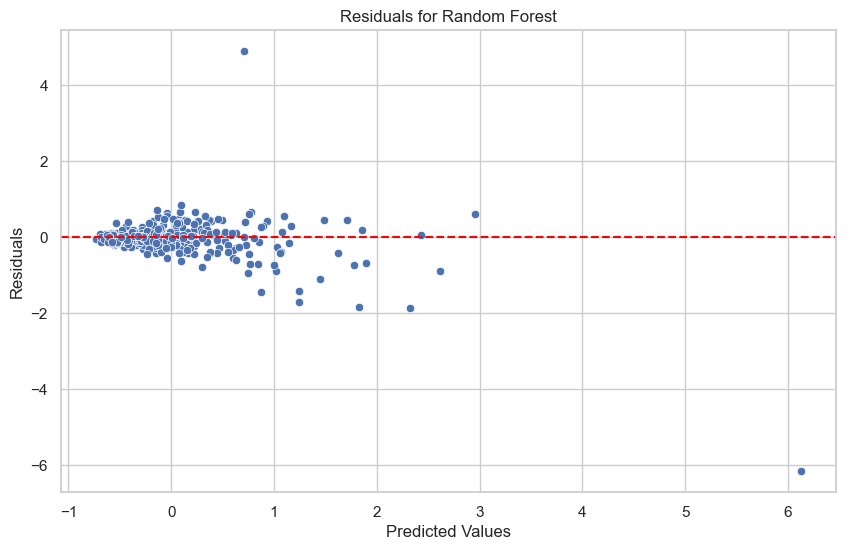

In [55]:
# Plot residuals for each model
plot_residuals(y_test, linear_predictions, "Linear Regression")
plot_residuals(y_test, decision_tree_predictions, "Decision Tree")
plot_residuals(y_test, random_forest_predictions, "Random Forest")
# plot_residuals(y_test, xgboost_predictions, "XGBoost")  # Uncomment if using XGBoost

In [57]:
# Create a Dummy Regressor
baseline_model = DummyRegressor(strategy='mean')

# Fit the baseline model
baseline_model.fit(X_train, y_train)

# Make predictions using the baseline model
baseline_predictions = baseline_model.predict(X_test)

# Evaluate the baseline model
evaluate_model(y_test, baseline_predictions, "Baseline Model (Dummy Regressor)")

# Compare with previously evaluated models
print("Comparison of Model Performance:")
print("---------------------------------------------------")
evaluate_model(y_test, linear_predictions, "Linear Regression")
evaluate_model(y_test, decision_tree_predictions, "Decision Tree")
evaluate_model(y_test, random_forest_predictions, "Random Forest")
# evaluate_model(y_test, xgboost_predictions, "XGBoost")  # Uncomment if using XGBoost

# Optionally, you can visualize the comparison of MAE, RMSE, and R²
models = ['Baseline', 'Linear Regression', 'Decision Tree', 'Random Forest']
mae_values = [
    mean_absolute_error(y_test, baseline_predictions),
    mean_absolute_error(y_test, linear_predictions),
    mean_absolute_error(y_test, decision_tree_predictions),
    mean_absolute_error(y_test, random_forest_predictions),
]

rmse_values = [
    np.sqrt(mean_squared_error(y_test, baseline_predictions)),
    np.sqrt(mean_squared_error(y_test, linear_predictions)),
    np.sqrt(mean_squared_error(y_test, decision_tree_predictions)),
    np.sqrt(mean_squared_error(y_test, random_forest_predictions)),
]

r2_values = [
    r2_score(y_test, baseline_predictions),
    r2_score(y_test, linear_predictions),
    r2_score(y_test, decision_tree_predictions),
    r2_score(y_test, random_forest_predictions),
]

# Creating a DataFrame for comparison
comparison_df = pd.DataFrame({
    'Model': models,
    'MAE': mae_values,
    'RMSE': rmse_values,
    'R²': r2_values
})

print(comparison_df)

Baseline Model (Dummy Regressor) Evaluation:
 - MAE: 0.42
 - RMSE: 0.61
 - R²: -0.01

Comparison of Model Performance:
---------------------------------------------------
Linear Regression Evaluation:
 - MAE: 0.23
 - RMSE: 0.39
 - R²: 0.59

Decision Tree Evaluation:
 - MAE: 0.25
 - RMSE: 0.47
 - R²: 0.41

Random Forest Evaluation:
 - MAE: 0.22
 - RMSE: 0.50
 - R²: 0.32

               Model       MAE      RMSE        R²
0           Baseline  0.418217  0.611219 -0.009176
1  Linear Regression  0.232970  0.390836  0.587368
2      Decision Tree  0.253372  0.466133  0.413059
3      Random Forest  0.223025  0.503417  0.315413


In [59]:
import joblib

# Assuming xgboost_model is your trained model
joblib.dump(xgboost_model, 'xgboost_model.pkl')


['xgboost_model.pkl']